In [30]:
import numpy as np
import pandas as pd

import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [31]:
data = pd.read_csv('data.csv')

In [32]:
data.head()

,Unnamed: 0,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
0,0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,jtezu11f88k007763,159348797,new jersey,usa,10 days left
1,1,2899,ford,se,2011,clean vehicle,190552.0,silver,2fmdk3gc4bbb02217,166951262,tennessee,usa,6 days left
2,2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,3c4pdcgg5jt346413,167655728,georgia,usa,2 days left
3,3,25000,ford,door,2014,clean vehicle,64146.0,blue,1ftfw1et4efc23745,167753855,virginia,usa,22 hours left
4,4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,3gcpcrec2jg473991,167763266,florida,usa,22 hours left


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2499 non-null   int64  
 1   price         2499 non-null   int64  
 2   brand         2499 non-null   object 
 3   model         2499 non-null   object 
 4   year          2499 non-null   int64  
 5   title_status  2499 non-null   object 
 6   mileage       2499 non-null   float64
 7   color         2499 non-null   object 
 8   vin           2499 non-null   object 
 9   lot           2499 non-null   int64  
 10  state         2499 non-null   object 
 11  country       2499 non-null   object 
 12  condition     2499 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 253.9+ KB


##

### Data Visualization

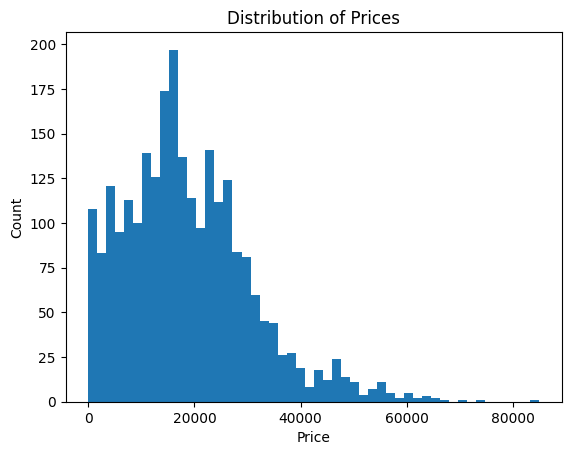

In [45]:
import matplotlib.pyplot as plt

plt.hist(data['price'], bins=50)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


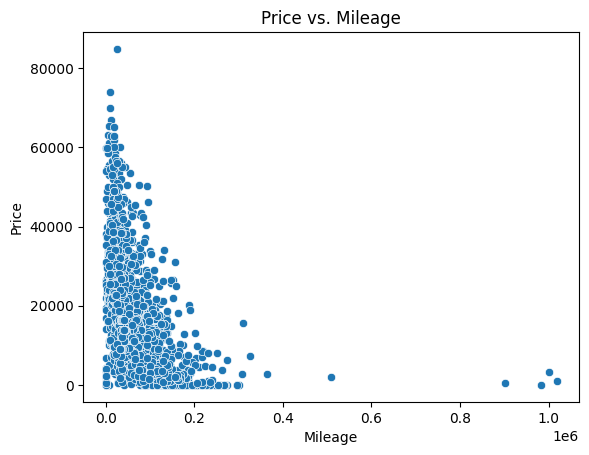

In [47]:
import seaborn as sns

sns.scatterplot(data=data, x='mileage', y='price')
plt.title('Price vs. Mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()


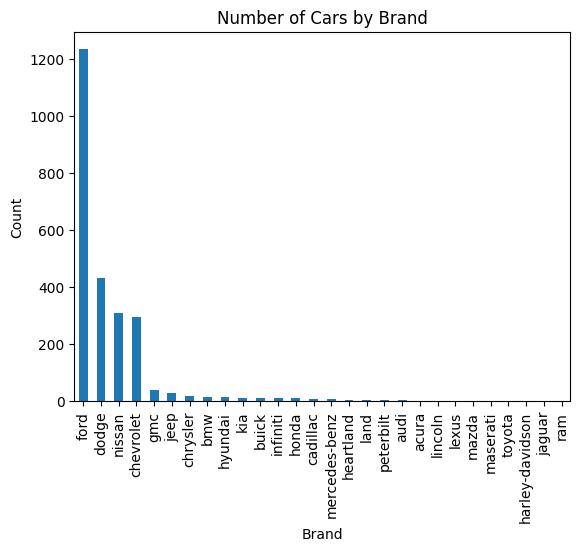

In [49]:

data['brand'].value_counts().plot(kind='bar')
plt.title('Number of Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()


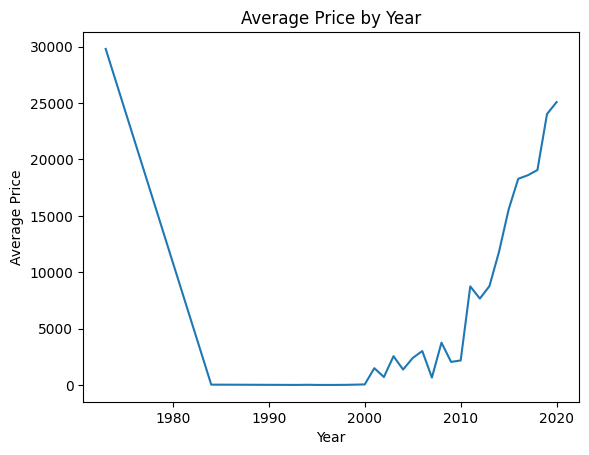

In [52]:
data.groupby('year')['price'].mean().plot()
plt.title('Average Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.show()



## Preprocessing of the data

In [34]:
def binary_encode(df, columns_with_positive_values):
    df = df.copy()
    for column, positive_value in columns_with_positive_values:
        df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def onehot_encode(df, columns_with_prefixes):
    df = df.copy()
    for column, prefix in columns_with_prefixes:
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1) 
    return df

In [35]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop unnecessary columns
    df = df.drop(['Unnamed: 0', 'vin', 'lot'], axis=1)
    
    # Binary encode the title_status and country columns
    df = binary_encode(
        df,
        columns_with_positive_values=[
            ('title_status', 'salvage insurance'),
            ('country', ' canada')
        ]
    )
    
    # One-hot encode the brand, model, color, state, and condition columns
    df = onehot_encode(
        df,
        columns_with_prefixes=[
            ('brand', 'br'),
            ('model', 'md'),
            ('color', 'cl'),
            ('state', 'st'),
            ('condition', 'cd')
        ]
    )
    
    # Fixes LightGBM error
    df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    
    # Split df into X and y
    y = df['price'].copy()
    X = df.drop('price', axis=1).copy()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    
    return X_train, X_test, y_train, y_test

In [36]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [38]:
X_train

,year,title_status,mileage,country,br_acura,br_audi,br_bmw,br_buick,br_cadillac,br_chevrolet,...,cd_5hoursleft,cd_53minutes,cd_6daysleft,cd_6hoursleft,cd_7daysleft,cd_7hoursleft,cd_8daysleft,cd_9daysleft,cd_9minutes,cd_ListingExpired
0,-1.288806,-0.260318,1.512784,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
1,0.372505,-0.260318,-0.522124,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
2,0.649390,-0.260318,-0.394639,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
3,-1.011921,-0.260318,0.592934,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,2.744396,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
4,0.649390,-0.260318,-0.625620,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,0.649390,-0.260318,-0.285273,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
1745,0.649390,-0.260318,-0.218108,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
1746,-0.458151,-0.260318,0.097645,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
1747,0.649390,-0.260318,-0.392006,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829


In [39]:
X_test

,year,title_status,mileage,country,br_acura,br_audi,br_bmw,br_buick,br_cadillac,br_chevrolet,...,cd_5hoursleft,cd_53minutes,cd_6daysleft,cd_6hoursleft,cd_7daysleft,cd_7hoursleft,cd_8daysleft,cd_9daysleft,cd_9minutes,cd_ListingExpired
0,0.649390,-0.260318,-0.456662,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
1,0.095620,-0.260318,-0.792068,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
2,0.372505,-0.260318,-0.608492,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
3,0.372505,-0.260318,-0.666984,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
4,0.649390,-0.260318,-0.668486,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-1.565692,-0.260318,0.364648,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
746,-2.119462,-0.260318,3.225790,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,2.744396,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
747,0.095620,-0.260318,0.137415,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,7.325043,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829
748,0.649390,-0.260318,-0.549519,-0.053544,-0.041451,-0.023918,-0.075832,-0.083117,-0.067787,-0.364379,...,-0.086536,-0.023918,-0.142899,-0.058671,-0.136518,-0.041451,-0.191707,-0.142899,-0.041451,-0.089829


In [40]:
# Putting all the model in a dictionary
models = {
    "                     Linear Regression": LinearRegression(),
    "                   K-Nearest Neighbors": KNeighborsRegressor(),
    "                        Neural Network": MLPRegressor(),
    "Support Vector Machine (Linear Kernel)": LinearSVR(),
    "   Support Vector Machine (RBF Kernel)": SVR(),
    "                         Decision Tree": DecisionTreeRegressor(),
    "                         Random Forest": RandomForestRegressor(),
    "                     Gradient Boosting": GradientBoostingRegressor(),
    "                               XGBoost": XGBRegressor(),
    "                              LightGBM": LGBMRegressor(),
    "                              CatBoost": CatBoostRegressor(verbose=0)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained successfully.")

                     Linear Regression trained successfully.
                   K-Nearest Neighbors trained successfully.


c:\Users\ariji\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


                        Neural Network trained successfully.
Support Vector Machine (Linear Kernel) trained successfully.
   Support Vector Machine (RBF Kernel) trained successfully.
                         Decision Tree trained successfully.
                         Random Forest trained successfully.
                     Gradient Boosting trained successfully.
                               XGBoost trained successfully.
                              LightGBM trained successfully.
                              CatBoost trained successfully.


In [41]:
for name, model in models.items():
    print(f"Prediction for {name}")
    print(model.predict(X_test))

Prediction for                      Linear Regression
[ 2.24818621e+04  2.99298621e+04  2.51978621e+04  2.42313621e+04
  4.58986207e+03  2.25778621e+04  1.84658621e+04  3.19358621e+04
  9.15986207e+03  2.54486121e+04  1.06338621e+04  1.56969871e+04
  2.87286121e+04  6.36861207e+03  5.53586207e+03  2.19438621e+04
  1.77978621e+04  4.23786207e+03  2.07298621e+04  1.27938621e+04
  6.17661207e+03 -8.86342742e+16  4.72418621e+04  1.44338621e+04
  1.53618621e+04  2.67018621e+04  1.81898621e+04  3.12658621e+04
  2.51686121e+04  1.94658621e+04  5.72186207e+03  2.87298621e+04
  3.27378621e+04  3.09118621e+04  8.94386207e+03  1.30018621e+04
  2.27618621e+04  4.61598621e+04  1.58889871e+04  1.61758621e+04
  2.51538621e+04  1.45438621e+04  3.02938621e+04  2.77858621e+04
  2.86818621e+04 -6.96613793e+03  2.77458621e+04  3.25862072e+02
  1.47618621e+04  1.67138621e+04  2.80178621e+04  1.28898621e+04
  1.39518621e+04  1.65938621e+04  4.02386207e+03  2.20338621e+04
  1.69358621e+04  2.66538621e+04  1.

In [42]:
from sklearn.metrics import r2_score

In [43]:

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(name + " R^2 Score: {:.5f}".format(r2_score(y_test, y_pred)))

                     Linear Regression R^2 Score: -155824765473722659543973888.00000
                   K-Nearest Neighbors R^2 Score: 0.45878
                        Neural Network R^2 Score: -1.16892
Support Vector Machine (Linear Kernel) R^2 Score: -1.89821
   Support Vector Machine (RBF Kernel) R^2 Score: -0.02643
                         Decision Tree R^2 Score: 0.47257
                         Random Forest R^2 Score: 0.63686
                     Gradient Boosting R^2 Score: 0.57211
                               XGBoost R^2 Score: 0.66053
                              LightGBM R^2 Score: 0.59239
                              CatBoost R^2 Score: 0.67971
